# Auswirkungen von Überschriften auf den Aktienkurs
<br>
<b>In diesem Notebook wird versucht eine Beziehung zwischen Überschriften von Nachrichten über Aktien (Aktiennews) und den dazu gehörigen Aktienpreisen darzustellen und zu belegen.</b><br>
Dazu wird ein Datensatzes von bot_developer <a href="https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests">Daily Financial News for 6000+ Stocks, Kaggle</a> mit Headlines zu Stocks sowie die Aktienpreise, bezogen durch eine API von <a href="https://www.polygon.io">Polygon.io</a>, herangezogen.
<br><br>
<i>Im folgenden wird nach dem CRISP-DM vorgegangen.</i>
<br><br>
@author DHR <br>
@author BKN <br>
Stand: 17.08.2021

(Die Markdown-Zellen sind in deutscher Beschreibung, der Code sowie auch die Code-Kommentare sind auf Englisch verfasst.)

## Hinweise zur Abgabe
* Der API call ist nicht mehr lauffähig, der API-Key liegt diesem Notebook nicht bei. Der API call hat eine Laufzeit von über 10 Stunden.
* Der apply des 'publish_count' hat eine Laufzeit von ca. 30min (liegt jedoch schon als csv vor).
* Der Merge der TF-IDF Matrix mit dem Preparierten Datensatz läuft bei normalen Einstellung in einen Memory-Allocation-Error (ein Workaround hilft, um mehr RAM zur Verfügung zu stellen).

## Requirements
Zur Installation aller benötigten Module nutzen Sie<br>
<code>python -m pip install -r requirements.txt</code> (keine Garantie für Vollständigkeit)<br>
<i>Dieses Notebook läuft auf <b>Python 3.9.5 </b> <br> Es wird die verwendung eines virtuellen Enviroments empfohlen</i>

In [1]:
# basic Python Modules
import os
import sys
import random
import datetime
import time

# basic DataScience Modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# basic Data Understanding
import statistics

# basic visualization for Data Understanding
from wordcloud import WordCloud

In [3]:
# headline cleaning
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')

from sentistrength import PySentiStr
# from stanfordcorenlp import StanfordCoreNLP
# nlp = StanfordCoreNLP(r'G:\JavaLibraries\stanford-corenlp-full-2018-02-27')


[nltk_data] Downloading package wordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dominik Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to C:\Users\Dominik
[nltk_data]     Höhr\AppData\Roaming\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


In [4]:
# api requirements
from polygon import RESTClient
from dotenv import load_dotenv
load_dotenv()

def unique(l):
    ## list of only the unique values from a given list
    x = np.array(l)
    return np.unique(x)

In [5]:
# Sentiment Modelling, Linear Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [6]:
# tf-idf Modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [7]:
# load the Dataset as pandas DataFrame
"""
bot_developer, Daily Financial News for 6000+ Stocks; Kaggle: (https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests)
"""
data = pd.read_csv('../data/raw_analyst_ratings.csv')

## Data Understanding

Die Daten wurden bisher nicht von uns bereinigt.

### First Look

In [8]:
# first Look
print(data.columns)
data.sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock'], dtype='object')


id                                           headline  \
1205779  1211581  DAVID FABER @davidfaber Tweet: $BUD is not in ...   
109435    110273  Activision Blizzard, Inc Reports Q4 EPS of $0....   
968291    973188  SunTrust 'Very Comfortable' With Pandora Assum...   
965286    970182  Mizuho Upgrades Occidental Petroleum, Says Wor...   
208562    209927  CEO Russo Buys 4,500 Shares of Calix @$7.55/Sh...   
906000    910674  UBS Downgrades Northrop Grumman from Neutral t...   
1271388  1277436          Stocks That Hit 52-Week Lows On Wednesday   

                                                       url      publisher  \
1205779  https://www.benzinga.com/media/cnbc/14/09/4848...  Charles Gross   
109435   https://www.benzinga.com/news/earnings/14/02/4...  Paul Quintaro   
968291   https://www.benzinga.com/analyst-ratings/analy...    Kevin Riley   
965286   https://www.benzinga.com/analyst-ratings/analy...    Priya Nigam   
208562   https://www.benzinga.com/news/16/07/8235177/ce...  Charles Gross   
906000   https://www.benzinga.com/analyst-ratings/downg...     Juan Lopez   
1271388  https://www.benzinga.com/news/20/03/15528100/s...     Lisa Levin   

                              date stock  
1205779        2014-09-15 00:00:00   TAP  
109435         2014-02-06 00:00:00  ATVI  
968291         2014-10-13 00:00:00     P  
965286         2020-01-08 00:00:00   OXY  
208562         2016-07-19 00:00:00  CALX  
906000         2012-09-13 00:00:00   NOC  
1271388  2020-03-11 11:41:58-04:00    TX

In [9]:
# some statistics about the DataFrame
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))
data.count()

observations: 1407328, features: 6 

unique headlines: 845770, unique stocks: 6204 



id           1407328
headline     1407328
url          1407328
publisher    1407328
date         1407328
stock        1407328
dtype: int64

In [10]:
# group by the stocks
stock = data.groupby("stock")
stock.sample()

id                                           headline  \
27            27  Shares of several healthcare companies are tra...   
1467        1869  Cramer Advises His Viewers On Alcoa, Xerox, Te...   
4254        4683  AAC Reaffirms FY17 Adj. EPS $0.50-$0.58 vs $0....   
4335        4764           3 ADR ETFs Your Broker Forgot to Mention   
4697        5137  Qatar Airways Will Not Proceed With Proposed I...   
...          ...                                                ...   
1405505  1412026             Stocks That Hit 52-Week Lows On Monday   
1405712  1412233  The Week Ahead In Biotech: Conferences, PDUFA ...   
1406243  1412764  TGIF As Markets Rally; S&P 500 Posts Longest W...   
1407006  1413527  Roth Capital Downgrades Zumiez from Buy to Neu...   
1407268  1413789  China Zenix Auto International Reports Q3 EPAD...   

                                                       url          publisher  \
27       https://www.benzinga.com/wiim/20/04/15748126/s...  Benzinga Newsdesk   
1467     https://www.benzinga.com/media/20/04/15806927/...        Craig Jones   
4254     https://www.benzinga.com/news/guidance/17/11/1...      Paul Quintaro   
4335     https://www.benzinga.com/trading-ideas/long-id...      ETF Professor   
4697     https://www.benzinga.com/news/17/08/9864222/qa...      Paul Quintaro   
...                                                    ...                ...   
1405505  https://www.benzinga.com/news/20/03/15560273/s...  Benzinga Newsdesk   
1405712  https://www.benzinga.com/general/biotech/18/07...   Shanthi Rexaline   
1406243  https://www.benzinga.com/news/earnings/14/10/4...     Jayson Derrick   
1407006  https://www.benzinga.com/analyst-ratings/downg...         Juan Lopez   
1407268  https://www.benzinga.com/news/earnings/17/12/1...      Paul Quintaro   

                              date stock  
27             2020-04-06 00:00:00     A  
1467           2020-04-15 00:00:00    AA  
4254           2017-11-01 00:00:00   AAC  
4335     2013-03-05 15:42:46-04:00  AADR  
4697           2017-08-02 00:00:00   AAL  
...                            ...   ...  
1405505  2020-03-16 11:51:23-04:00   ZTR  
1405712        2018-07-28 00:00:00   ZTS  
1406243        2014-10-17 00:00:00    ZU  
1407006        2012-06-21 00:00:00  ZUMZ  
1407268  2017-12-06 07:04:31-04:00    ZX  

[6204 rows x 6 columns]

#### Range of Date

In [11]:
# Range of Date
print("Der Datensatz erstreckt sich über einen Datumsspanne vom "+ data['date'].min()[0:10] +" bis zum "+ data['date'].max()[0:10] +"\nDabei besteht der Datensatz aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich über einen Datumsspanne vom 2009-02-14 bis zum 2020-06-11
Dabei besteht der Datensatz aus 1407328 Einträgen


In [12]:
date_withYear = data.assign(year = lambda dataframe: dataframe['date'].map(lambda date: date[0:4]))

Text(0, 0.5, 'Number of Healines')

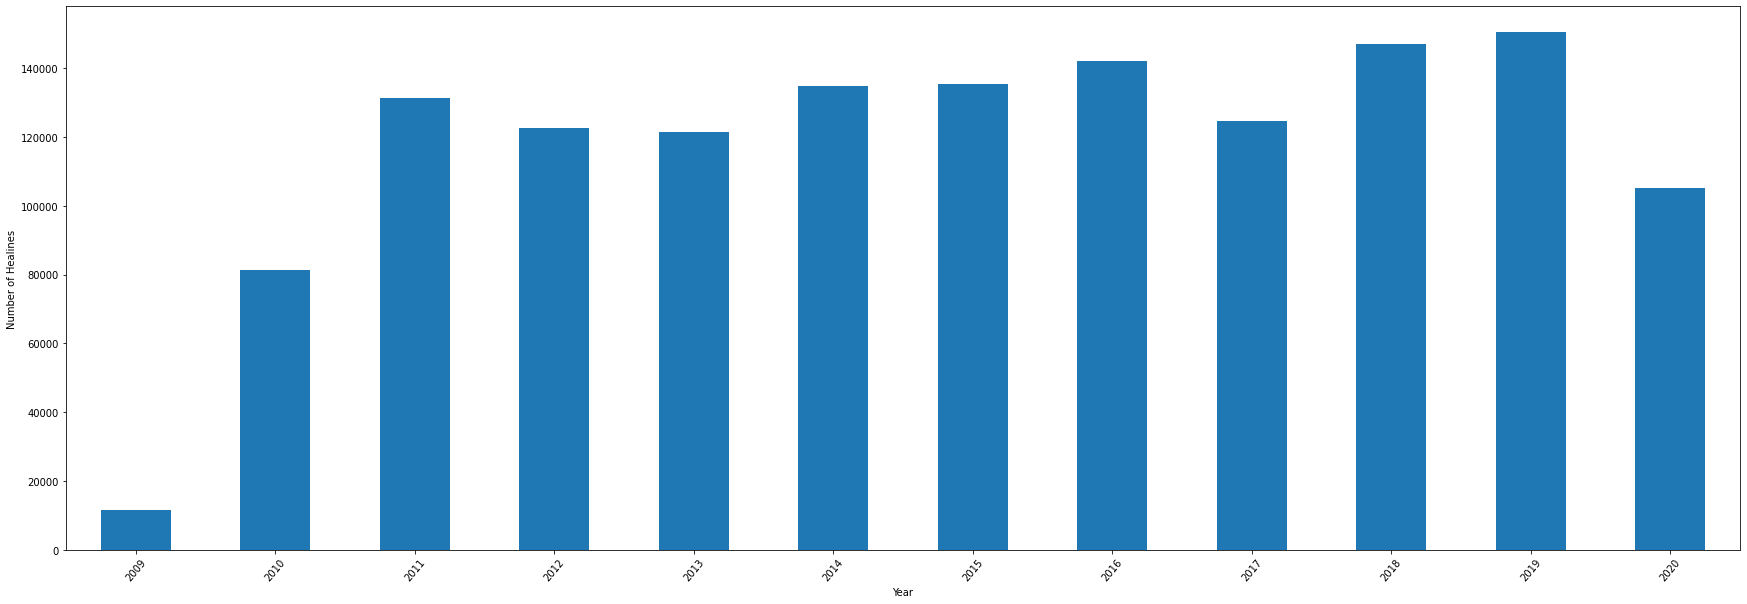

In [13]:
# Number of Date by Year
year = date_withYear.groupby("year")

plt.figure(figsize=(30,10))
year.size().plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Year")
plt.ylabel("Number of Healines")

In [14]:
# Average Count of Headlines by Year
print('Durchschnittliche Anzahl an Aktiennews über die Jahr: ', statistics.mean(year.size()))

Durchschnittliche Anzahl an Aktiennews über die Jahr:  117277.33333333333


### Data Visualization

Verteilung und Menge

<AxesSubplot:>

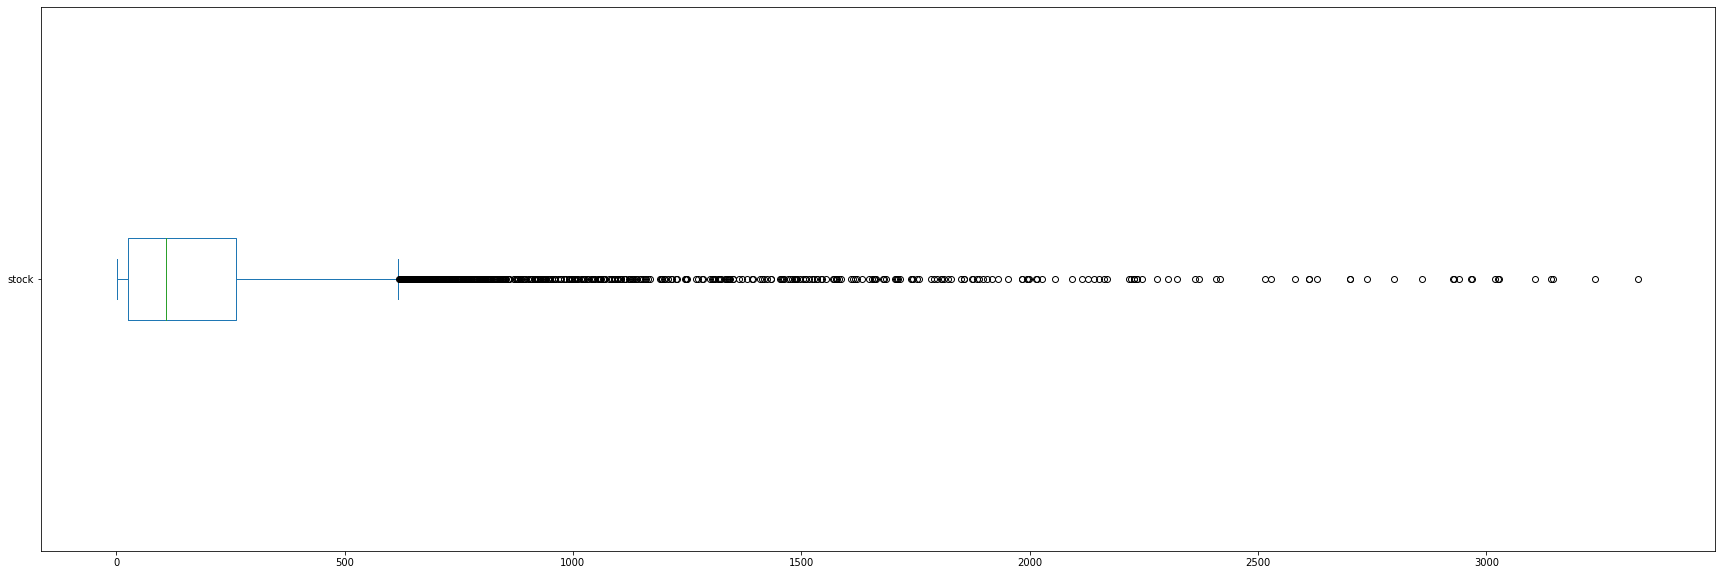

In [15]:
# BoxPlot of Stocks
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

<AxesSubplot:>

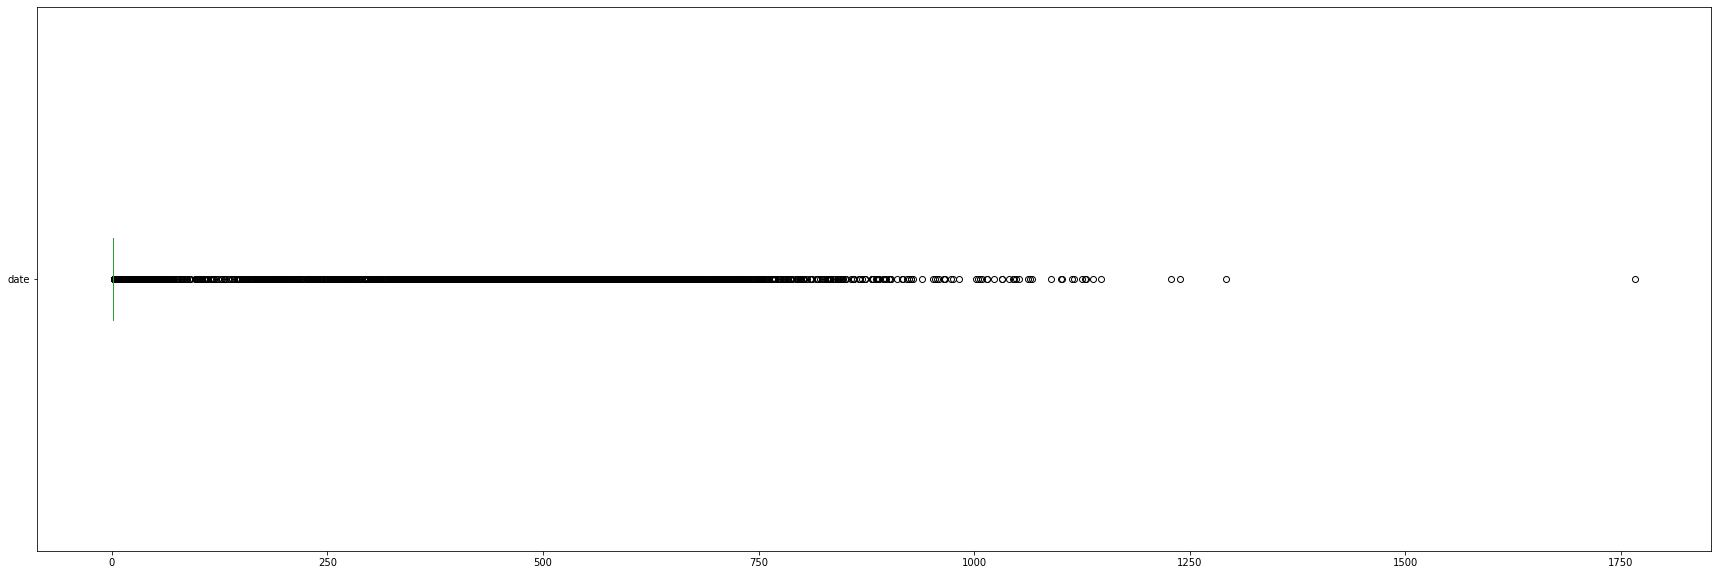

In [16]:
# BoxPlot of Date
data['date'].value_counts().plot.box(vert=False, figsize=(30,10))

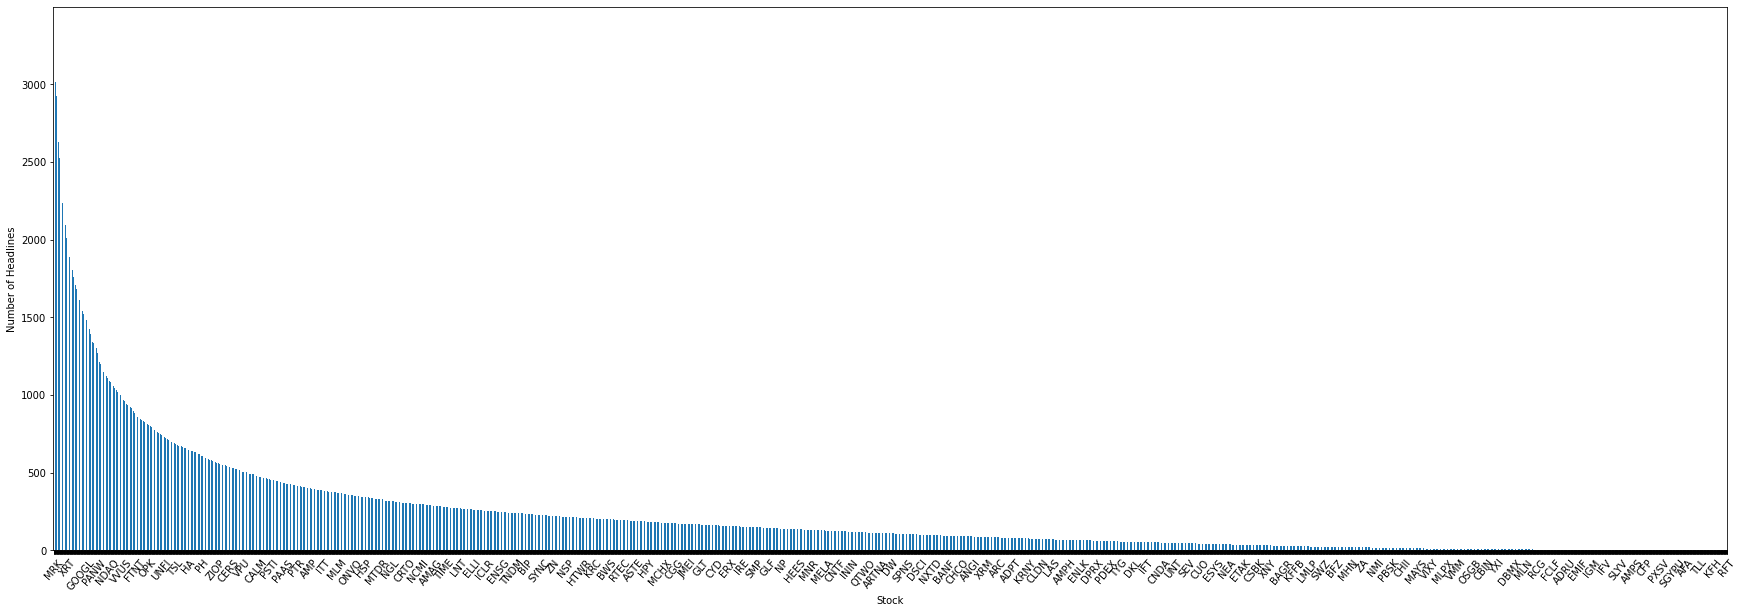

In [17]:
# Number of Headlines by Stock
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False)[0:6204].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

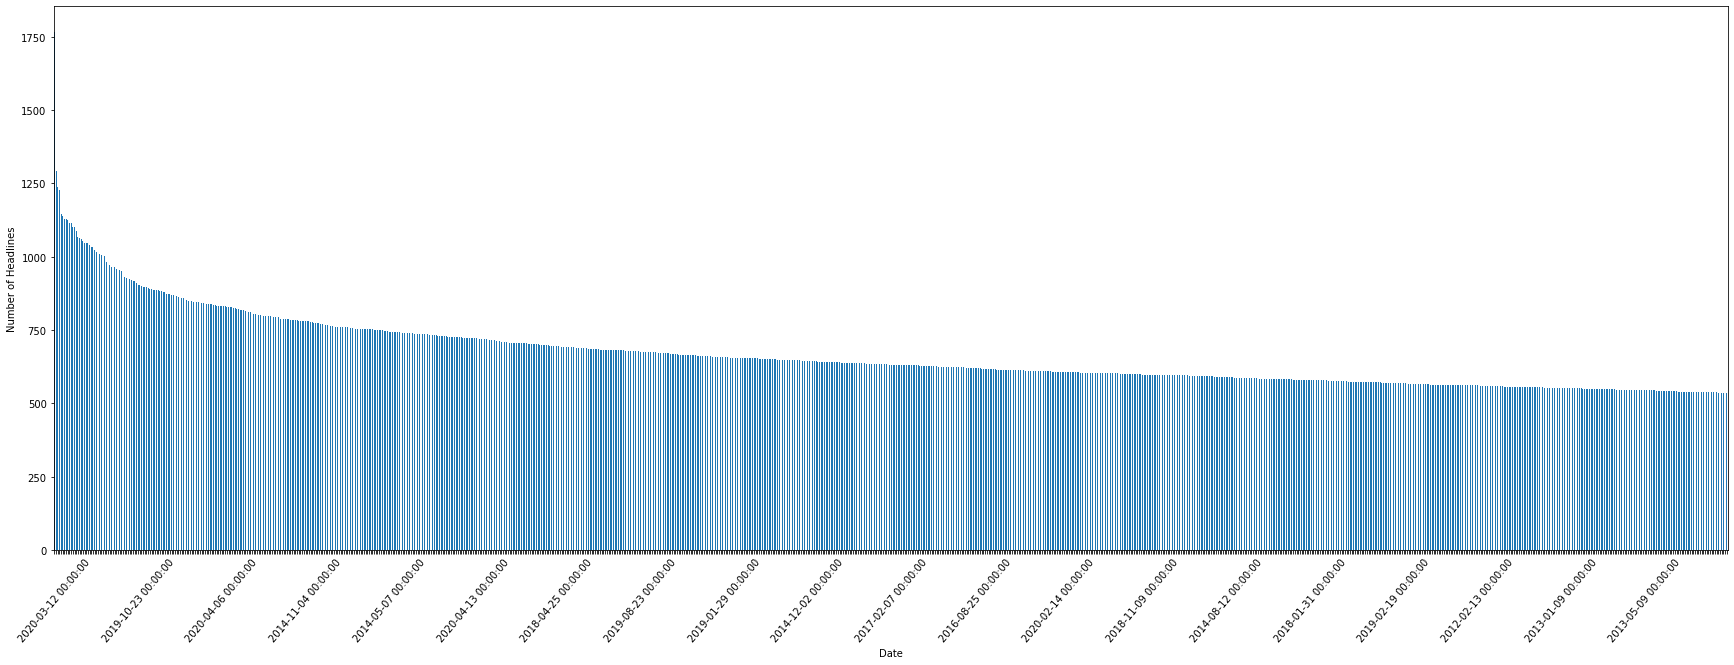

In [18]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False)[0:1000].plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

#### Wordclouds

Ohne Bereinigung oder Stopword-Removal

WorldCloud over all Stocks, Top 50 Words:


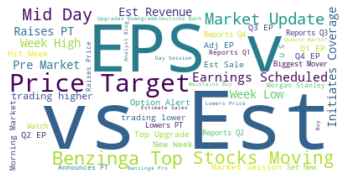

In [19]:
# Wordcloud for all Headlines together

# combine all headlines to one text
text = " ".join(headline for headline in data.headline)
maxWords = 50

# wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text)

# plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save
wordcloud.to_file("./results/wordcloud.png")

WorldCloud for Random Stock: FFHL, Top 50 Words:


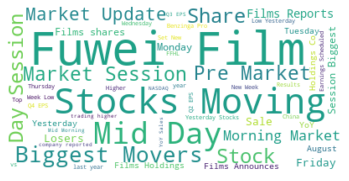

In [20]:
# Wordcloud for one random Stock

#combine all headlines of one Stock
stockFilter = random.choice(unique(data['stock']))
maxWords = 50
text_SpecificStock = " ".join(headline for headline in data[data["stock"]==stockFilter].headline)

#wordcloud
#!! No Stopword removal
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_SpecificStock)

#plot
print("WorldCloud for Random Stock: " + stockFilter + ", Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#save
wordcloud.to_file("./results/wordcloud_stock-"+ stockFilter +".png")

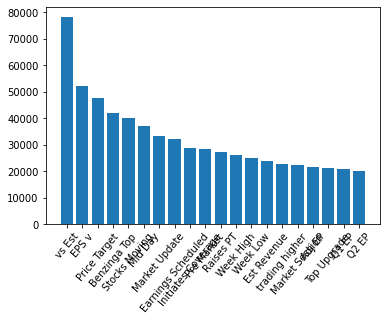

In [21]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

### Data Quality

In [22]:
# count all null values in the DataFrame
print("Anzahl von null Werten im gesamten DataFrame: "+str(data.isna().sum().sum()))
# count all dates without time, no need to format in isoFormat
print("Anzahl Zeitstempel ohne konkrete Uhrzeit: "+ str(data['date'].str.count('00:00:00').sum()))
# count duplicated
print("Anzahl Doppelten Einträgen: "+ str(data.duplicated().sum()))

Anzahl von null Werten im gesamten DataFrame: 0
Anzahl Zeitstempel ohne konkrete Uhrzeit: 1351341
Anzahl Doppelten Einträgen: 0


## Data Preparation

### Clean

In [23]:
# format datetime to date
data = data.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

# delete all rows older than 2years, because of API and Performance
data = data.drop(data[data.date < '2019-08-21'].index)


In [24]:
# clean the Stocks
# Remove Rows with Stocks that occur less than occ times
occ = 0
data = data[data.groupby('stock').stock.transform(len) > occ]

In [25]:
print("Der Datensatz erstreckt sich nun über einen Datumsspanne vom "+ data['date'].min() +" bis zum "+ data['date'].max() +"\nDabei besteht der Datensatz jetzt aus "+ str(data.headline.count()) + " Einträgen")

Der Datensatz erstreckt sich nun über einen Datumsspanne vom 2019-08-21 bis zum 2020-06-11
Dabei besteht der Datensatz jetzt aus 164698 Einträgen


#### Headline Cleaning & Pre-Processing
Hier wird nochmal speziell jede einzelene Headline den typischen pre-processing Schritten unterzogen

##### Define Headline Preprocessing
Requierements and def of Functions

In [26]:
# Part Of Speech Tagging suppling lemmatization

def tokenize_post(headline):
    hl_tokenz = word_tokenize(headline)
    hl_post = nltk.pos_tag(hl_tokenz)
    hl_post_result = []
    for word in hl_post:
        if word[1].startswith('NN'):
            hl_post_result.append([word[0], 'n'])
        elif word[1].startswith('JJ'):
            hl_post_result.append([word[0], 'a'])
        elif word[1].startswith('V'):
            hl_post_result.append([word[0], 'v'])
        elif word[1].startswith('R'):
            hl_post_result.append([word[0], 'r'])
        else:
            hl_post_result.append([word[0], ''])
    return hl_post_result

In [27]:
# Stopword-removal
# Stopwords from NLTK Modul
def remove_stopwords(hl_post_tok_lower):
    stop_words = set(stopwords.words('english')) 

    # possible custom stopwords
    # stop_words.add('')

    filtered_sentence = [word for word in hl_post_tok_lower if not word[0] in stop_words]
    return filtered_sentence

In [28]:
# WortNetLemmatizer Function for lemmatization
lemmatizer = WordNetLemmatizer()

# this headline is pos-tagged, tokenzied, lower, and stopwords-removed
def lemmatize(headline):
    lemmatized_output = []
    for word in headline:
        if word[1] == '':
            lemmatized_output.append((lemmatizer.lemmatize(word[0]), word[1]))
        else:
            lemmatized_output.append((lemmatizer.lemmatize(word[0], pos=word[1]), word[1]))
    # remove less than two char
    lemmatized_output = [word for word in lemmatized_output if len(word[0]) > 2]
    # remove numeric
    lemmatized_output = [word for word in lemmatized_output if not word[0].isnumeric()]
    
    return lemmatized_output

In [29]:
# use most used synonym for the words, suppling Sentiments
def getSynset(headline):
    synset_output = []
    for word in headline:
        synsets = wn.synsets(word[0], pos=word[1])
        if len(synsets)>0:
            synset_output.append((synsets[0].name()))
        # remove word if no sentiment found
        # else:
        #     synset_output.append(word[0]+ "." +word[1]+".01")
    return synset_output

In [30]:
# calculate sentiment
senti_pos_score = []
senti_neg_score = []

senti_score = []

def getSentiment(headline):
    senti_pos = 0
    senti_neg = 0
    # senti_obj = 0
    for word in headline:
        swn_synset = swn.senti_synset(word)
        senti_pos += swn_synset.pos_score()
        senti_neg += swn_synset.neg_score()

    senti_pos_score.append(senti_pos)
    senti_neg_score.append(senti_neg)

    senti_score.append(senti_pos - senti_neg)
    # senti_obj_score.append(swn_synset.obj_score())
    return headline

##### Apply Headline Preprocessing

In [31]:
# headline as lowercase in a new colum
data['headline_cleaned'] = data['headline'].apply(lambda headline: headline.lower())

In [32]:
# tokenization und POS-Tagging
data['headline_cleaned'] = data['headline'].apply(tokenize_post)

In [33]:
# stopword-removal
data['headline_cleaned'] = data['headline_cleaned'].apply(remove_stopwords)

In [34]:
# lemmatization
data['headline_cleaned'] = data['headline_cleaned'].apply(lemmatize)

In [35]:
# replace by most used synonym
data['headline_cleaned'] = data['headline_cleaned'].apply(getSynset)

In [36]:
# calculate Sentiment
data['headline_cleaned'] = data['headline_cleaned'].apply(getSentiment)

# add Sentiment to DataFrame
data['senti_pos_score'] = senti_pos_score
data['senti_neg_score'] = senti_neg_score
data['senti_score'] = senti_score

In [37]:
#Export as csv for faster access
data.to_csv('../data/analyst_ratings_processed_hl_cleaned.csv', index=False)

### Construct

#### API call to get StockPrices for all stocks
verwendete API : 'https://polygon.io/' <br>
(benötigt Timeouts zwischen den API calls da die API max 5 Api calls pro Minute bedient)

In [38]:
# List of Stock Ticker to call
stocks_unique = unique(data['stock'])
print("Es verbleiben "+str(len(stocks_unique))+" eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen")

Es verbleiben 3807 eindeutige Stocks, zur Anfrage an der API, welche im Zeitraum der Verfügbaren API liegen


In [ ]:
# API call with TimeOut (5 per minute)
key = os.environ.get("POLYGON_IO_API_KEY") # API key in .env
apiResults = []
apiCount = 0

def apiCall(stocks_unique):
    for s in stocks_unique:
        # the API only response to 2years historical dates
        from_ = '2019-08-21'
        to =  '2020-12-31'

        # The API call
        with RESTClient(key) as client:
            resp = client.stocks_equities_aggregates(s, 1, "day", from_, to, unadjusted=False)
            # save the nessecary attributes of the JSON as List
            if (resp and hasattr(resp, 'results')):
                for result in resp.results:
                    dt = datetime.datetime.fromtimestamp(result['t'] / 1000.0).isoformat()
                    apiResults.append([s, dt, result['o'], result['h'], result['l'], result['c']])
            # if there are no results to a specific stock add it any ways to the List, so later the quality of the DataFrame can be controlled 
            else: 
                apiResults.append([s])
                print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___no_Results___")
        apiCount+=1
        print("["+datetime.datetime.now().isoformat() +"]" + " - API-Call Nr. " + str(apiCount) + " for Stock: " + s + " ___success___")
        time.sleep(12)
#apiCall(stocks_unique) ' Dont Run, because of Runtime and API-Key

# save the List-Data as DataFrame
stock_prices = pd.DataFrame(apiResults, columns=['stock', 'date', 'open', 'high', 'low', 'close'])
# save the DataFrame as csv
stock_prices.to_csv('../data/raw_stock_prices.csv', encoding='utf-8', index=False)

In [39]:
#get the API data from the csv to DataFrame
stock_prices = pd.read_csv('../data/raw_stock_prices.csv')

##### Overview over the API Data

In [40]:
# count of the DataFrame
stock_prices.count()

stock    1227563
date     1227498
open     1227498
high     1227498
low      1227498
close    1227498
dtype: int64

In [41]:
# First Look
print(stock_prices.columns)
stock_prices.sample(7)

Index(['stock', 'date', 'open', 'high', 'low', 'close'], dtype='object')


stock                 date    open      high       low   close
1119734   UAN  2020-03-27T05:00:00   11.30   11.3000   10.0000   10.20
1037569  STAG  2020-03-23T05:00:00   20.60   20.7000   17.5400   18.31
360405    EOD  2020-03-31T06:00:00    3.78    3.8600    3.6400    3.70
665112    LQD  2020-03-11T05:00:00  128.08  128.2699  123.2000  123.85
1221993  YUMA  2019-09-16T06:00:00    6.40    6.5900    4.7191    5.25
805578    NXJ  2020-03-11T05:00:00   14.88   14.8917   14.3300   14.49
354598   ENBL  2020-06-05T06:00:00    5.52    6.4800    5.4600    6.43

In [42]:
# count NaN rows
nanStocks = stock_prices[stock_prices['open'].isna() & stock_prices['close'].isna()]['stock']
print("Total Count of Stocks with NaN: " + str(len(nanStocks)))

Total Count of Stocks with NaN: 65


#### Combine DataFrame
füge den open und den close Preis der Aktie zur Headline am gleichen Tag hinzu

In [43]:
# remove headlines with NaN stock prices
data = data.drop(data[data['stock'].isin(nanStocks)].index)

# remove NaN stocks
stock_prices = stock_prices.drop(stock_prices[stock_prices.open.isna() & stock_prices.close.isna()].index)

In [44]:
# format datetime to date as above for the data DataFrame
stock_prices = stock_prices.assign(
    date = lambda dataframe: dataframe['date'].map(lambda date: date[0:10])
)

In [45]:
# remove headlines with date that are not covered by the stockprices -> probably Weekend
# datetime.datetime.fromisoformat().weekday() in [5,6]
data = data.drop(data[~data['date'].isin(stock_prices['date'])].index) # ~ means NOT IN
print('Anzahl der Aktien im DataFame der Aktienpreise die, nach dem bereinigen, Null sind:\n', stock_prices.isna().sum())

Anzahl der Aktien im DataFame der Aktienpreise die, nach dem bereinigen, Null sind:
 stock    0
date     0
open     0
high     0
low      0
close    0
dtype: int64


In [46]:
# Merge to the Final DataFrame
data = pd.merge(data, stock_prices[['stock', 'date', 'open', 'close']], on=['stock', 'date'])

#### Calculate Binary
##### Sentiment and Stockprice change
positive Sentiment = 1;
neutral Sentiment = 0;
negative Sentiment = -1

Stock Price Increase by more than x = 1;
Stock Price doesnt change more than x = 0;
Stock Price Decrease by more than x = -1

In [47]:
# calculate absolute values for the Stock Movement between [-1,1]
x=0.01
def stockDevelopment(row):
    # stock_differenz = row['open'] - row['close']
    quotient = row['close']/row['open']
    if quotient < (1-x):
        return -1
    elif quotient > (1+x):
        return 1
    else: return 0

In [48]:
# calculate absolute values for the Sentiment between [-1,1]
def getBinarySenti(row):
    if row["senti_score"] < 0:
        return -1
    elif row['senti_score'] > 0:
        return 1
    else: return 0

In [49]:
# add new colum with the "binary" Stockprice change
data["stockPrice_Change"] = data.apply(stockDevelopment, axis=1)

In [50]:
# add new colum with the "binary" Sentiment
data['senti_Binary'] = data.apply(getBinarySenti, axis=1)

In [51]:
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7)

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Change', 'senti_Binary'],
      dtype='object')


id                                           headline  \
69844    606142  UPDATE: Raymond James Maintains Outperform On ...   
130589  1147342  Barclays Maintains Overweight on Schlumberger,...   
132799  1171685           Stocks That Hit 52-Week Highs On Tuesday   
143032  1259436  Raymond James Maintains Outperform on TriState...   
19921    165507  Shares of several companies in the financial s...   
17694    142037           Stocks That Hit 52-Week Lows On Thursday   
64337    565330  GenMark Diagnostics Q1 EPS $(0.120) Beats $(0....   

              date stock                                   headline_cleaned  \
69844   2020-05-20    HD  [update.n.01, james.n.01, home.n.01, terminal....   
130589  2020-03-31   SLB  [corpulence.n.01, lower_berth.n.01, monetary_v...   
132799  2020-06-02  SPLK   [stocks.n.01, hit.v.01, high.n.01, tuesday.n.01]   
143032  2019-08-29   TSC  [james.n.01, capital.n.01, retention.n.01, low...   
19921   2020-05-13    BK  [share.n.01, several.s.01, company.n.01, fisca...   
17694   2020-03-12   BBL   [stocks.n.01, hit.v.01, low.n.01, thursday.n.01]   
64337   2020-05-04  GNMK  [nosology.n.01, beat_generation.n.01, estimate...   

        senti_pos_score  senti_neg_score  senti_score    open   close  \
69844             0.625            0.500        0.125  242.00  238.19   
130589            0.000            0.125       -0.125   13.88   13.49   
132799            0.125            0.000        0.125  189.20  188.54   
143032            0.000            0.125       -0.125   19.32   19.78   
19921             1.250            2.125       -0.875   32.62   32.49   
17694             0.000            0.000        0.000   25.17   24.41   
64337             0.000            0.500       -0.500   11.80   11.74   

        stockPrice_Change  senti_Binary  
69844                  -1             1  
130589                 -1            -1  
132799                  0             1  
143032                  1            -1  
19921                   0            -1  
17694                  -1             0  
64337                   0            -1

### Export The Final DataFrame

In [52]:
# export final DataSet as csv
data.to_csv('../data/analyst_ratings_processed_final.csv', index=False)

In [7]:
# import final DataSet for Modelling
# # # data = pd.read_csv('../data/analyst_ratings_processed_final.csv')

### Overview

#### Final Look

In [54]:
# final Look
print(data.columns)
data.drop(columns=['publisher', 'url']).sample(7) #drop the colum just for the sample for better overview

Index(['id', 'headline', 'url', 'publisher', 'date', 'stock',
       'headline_cleaned', 'senti_pos_score', 'senti_neg_score', 'senti_score',
       'open', 'close', 'stockPrice_Change', 'senti_Binary'],
      dtype='object')


id                                           headline  \
142427  1255042  Trovagene Presents Overview Of Phase 1b/2 Tria...   
125187  1102026  Susquehanna Downgrades Range Resources to Nega...   
80287    705435    28 Stocks Moving in Friday's Pre-Market Session   
89505    791176  Shares of several retail companies are trading...   
59700    518618            Stocks That Hit 52-Week Highs On Monday   
11002     83305           Stocks That Hit 52-Week Highs On Tuesday   
126959  1113910   34 Stocks Moving in Tuesday's Pre-Market Session   

              date stock                                   headline_cleaned  \
142427  2019-10-01  TROV  ['present.n.01', 'overview.n.01', 'phase.n.01'...   
125187  2020-01-13   RRC  ['susquehanna.n.01', 'downgrade.n.01', 'scope....   
80287   2019-08-30   JKS  ['stocks.n.01', 'travel.v.01', 'friday.n.01', ...   
89505   2020-02-27     M  ['share.n.01', 'several.s.01', 'company.n.01',...   
59700   2019-11-04  FSBW  ['stocks.n.01', 'hit.v.01', 'high.n.01', 'mond...   
11002   2020-02-11   AON  ['stocks.n.01', 'hit.v.01', 'high.n.01', 'tues...   
126959  2020-04-28  SANM  ['stocks.n.01', 'travel.v.01', 'tuesday.n.01',...   

        senti_pos_score  senti_neg_score  senti_score    open   close  \
142427            0.125            0.125        0.000    1.49    1.34   
125187            0.000            0.375       -0.375    4.70    4.55   
80287             0.000            0.000        0.000   21.15   21.87   
89505             0.000            1.625       -1.625   13.09   12.90   
59700             0.125            0.000        0.125   28.75   28.74   
11002             0.125            0.000        0.125  232.00  231.22   
126959            0.000            0.000        0.000   26.51   26.93   

        stockPrice_Change  senti_Binary  
142427                 -1             0  
125187                 -1            -1  
80287                   1             0  
89505                  -1            -1  
59700                   0             1  
11002                   0             1  
126959                  1             0

In [55]:
# some statistics about the final DataFrame
print("observations: {}, features: {} \n".format(data.shape[0], data.shape[1]))
print("unique headlines: {}, unique stocks: {} \n".format(len(data.headline.unique()), len(data.stock.unique())))
data.count()

observations: 161478, features: 14 

unique headlines: 76162, unique stocks: 3722 



id                   161478
headline             161478
url                  161478
publisher            161478
date                 161478
stock                161478
headline_cleaned     161478
senti_pos_score      161478
senti_neg_score      161478
senti_score          161478
open                 161478
close                161478
stockPrice_Change    161478
senti_Binary         161478
dtype: int64

#### Visialization
Verteilung und Menge

<AxesSubplot:>

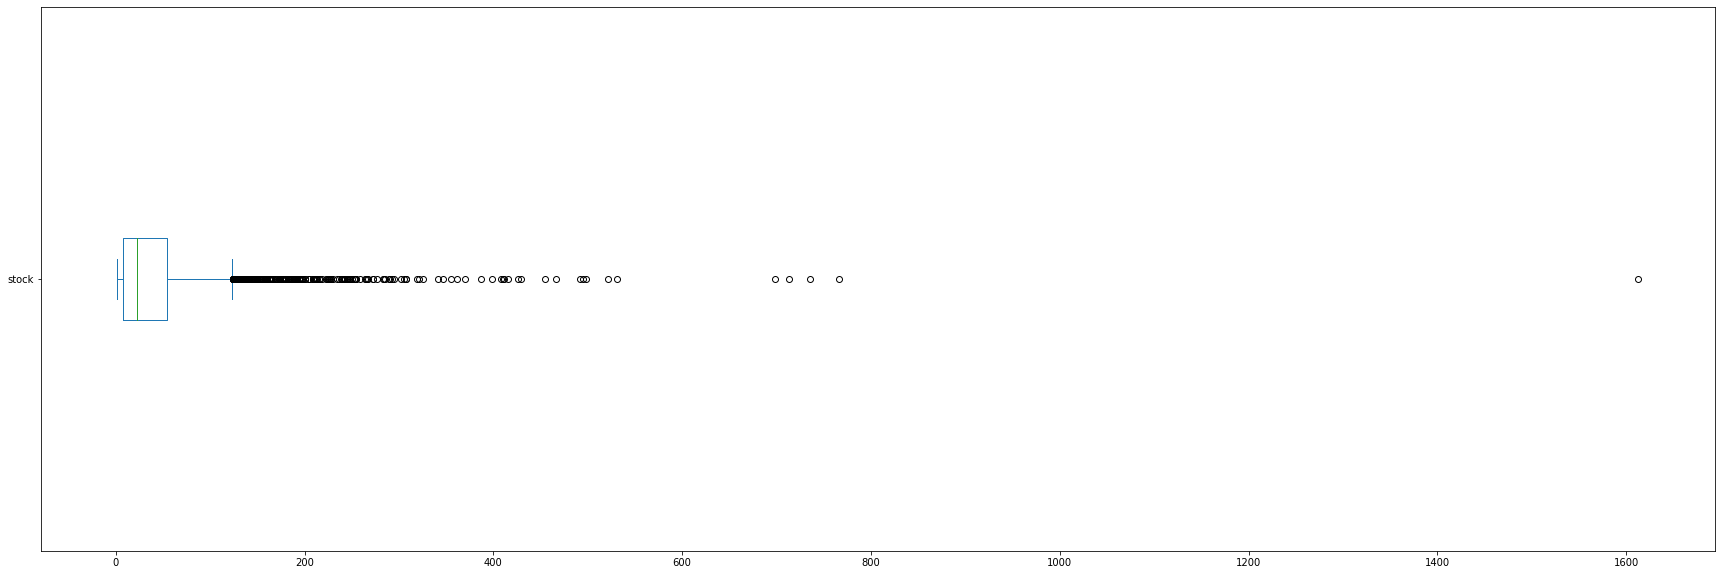

In [56]:
# BoxPlot of Stocks as above
data['stock'].value_counts().plot.box(vert=False, figsize=(30,10))

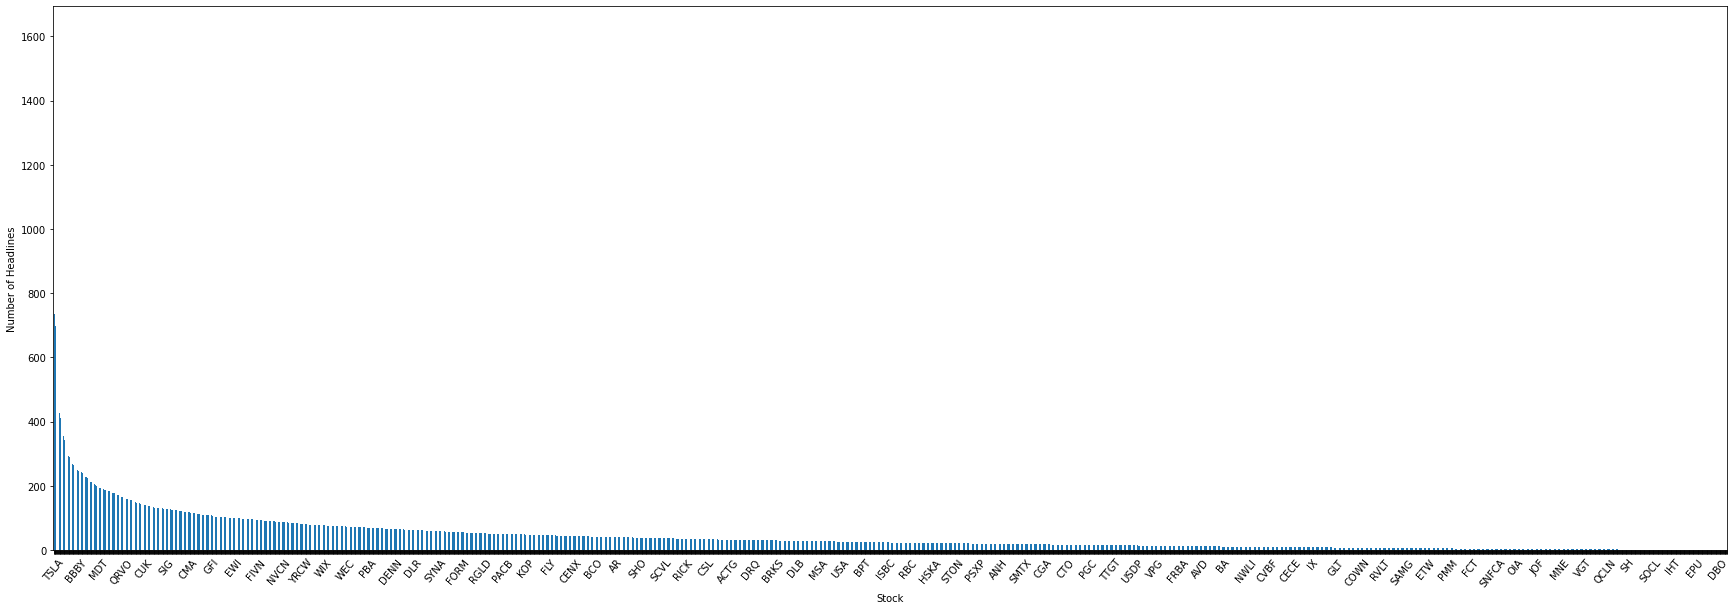

In [57]:
stock = data.groupby("stock")

# Number of Headlines by Stock as above
plt.figure(figsize=(30,10))
ax = stock.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Stock")
plt.ylabel("Number of Headlines")
#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

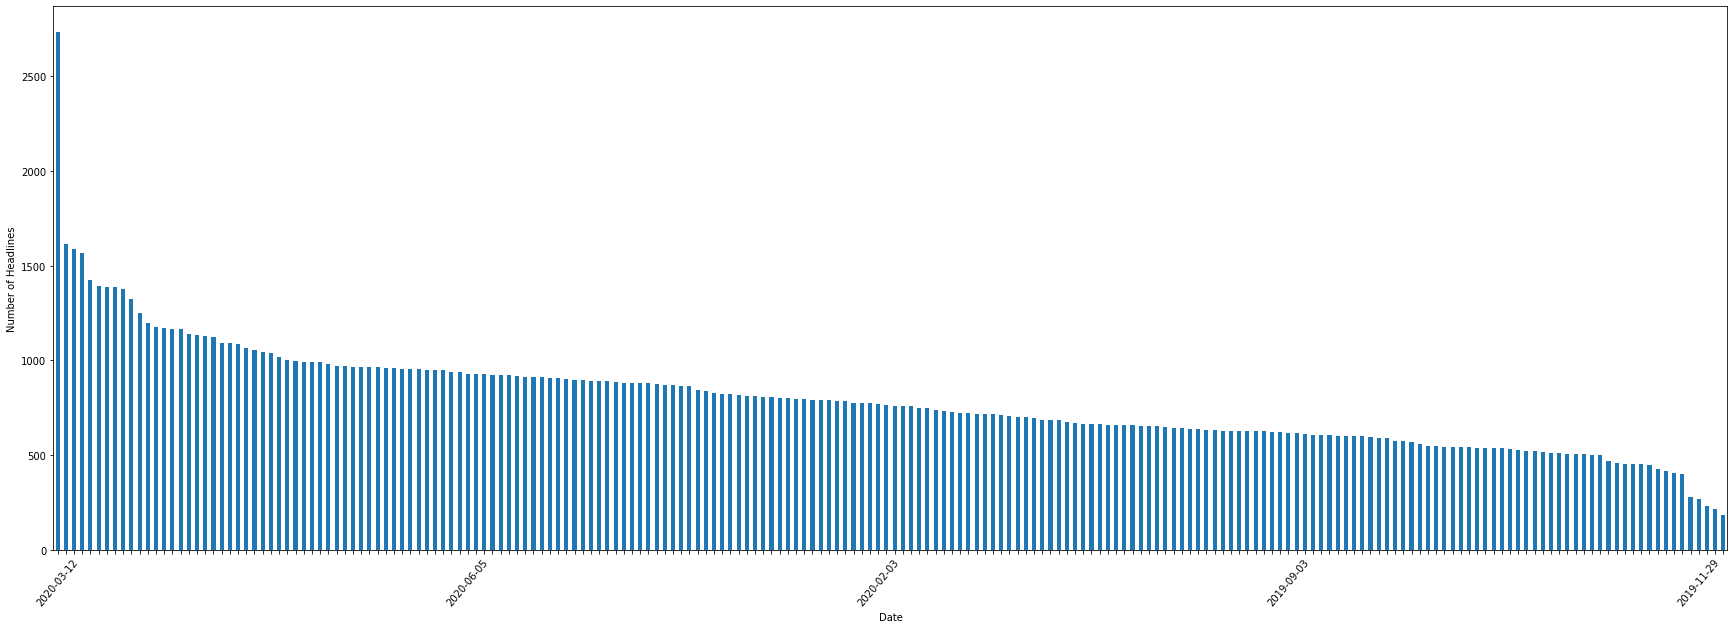

In [58]:
# Number of Headlines by Date
date = data.groupby("date")

plt.figure(figsize=(30,10))
ax = date.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("Date")
plt.ylabel("Number of Headlines")

#only display every n Label
n = 50
for i, t in enumerate(ax.get_xticklabels()):
    if (i % n) != 0:
        t.set_visible(False)
plt.show()

#### Wordcloud
Nach dem Bereinigen der Daten, inkl. Stopword Removal

WorldCloud over all Stocks, Top 50 Words:


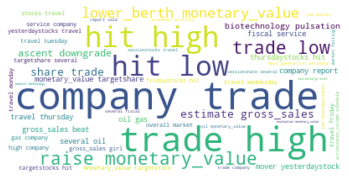

In [59]:
# Wordcloud for all Headlines

# combine all headlines to one text
text_afterCleaning = " "
for headline in data.headline_cleaned:
    text_afterCleaning = text_afterCleaning + ' '.join(list(map(lambda s: s.strip()[1:-5].replace('.',''), headline[1:-1].split(','))))

maxWords = 50
# wordcloud
wordcloud = WordCloud(background_color='white', max_words=maxWords).generate(text_afterCleaning)

# plot
print("WorldCloud over all Stocks, Top " + str(maxWords) + " Words:")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# save
wordcloud.to_file("./results/wordcloud_afterCleaning.png")

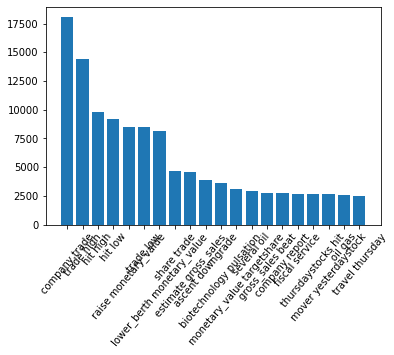

In [60]:
# Top n-Words
n = 20

wordFreq = WordCloud().process_text(text_afterCleaning)
wordFreq = dict(sorted(wordFreq.items(), key=lambda item: item[1], reverse=True)[:n])

plt.bar(range(len(wordFreq)), list(wordFreq.values()), align='center')
plt.xticks(range(len(wordFreq)), list(wordFreq.keys()), rotation=50)
plt.show()

## Modelling

### Simple Corellation
Überprüfe ob der Aktienpreis direkt mit dem Sentiment der Überschrift der Aktiennews zusammenhängt

positive correlation = 1 (sentiment == Positive -> stock price increase; sentiment == Negative -> stock price decrease); <br>
negative correlation = -1 (sentiment == Positive -> stock price decrease; sentiment == Negative -> stock price increase); <br>
neutral correlation = 0 (senti_Binary == 0 and stockPrice_Change == 0)

In [90]:
data.describe().transpose()

count           mean            std     min         25%  \
id                 161478.0  705046.579522  411428.843694  0.0000  340451.250   
senti_pos_score    161478.0       0.230588       0.370747  0.0000       0.000   
senti_neg_score    161478.0       0.286830       0.512116  0.0000       0.000   
senti_score        161478.0      -0.056242       0.458934 -4.2500      -0.125   
open               161478.0      90.353547    2099.671264  0.0500      10.000   
close              161478.0      90.391451    2102.522520  0.0791       9.970   
stockPrice_Change  161478.0      -0.022505       0.834898 -1.0000      -1.000   
senti_Binary       161478.0       0.047251       0.784989 -1.0000      -1.000   
publish_count      161478.0       3.401863       4.205390  1.0000       1.000   

                          50%           75%          max  
id                 707213.500  1.065472e+06  1412892.000  
senti_pos_score         0.125  2.500000e-01        4.000  
senti_neg_score         0.000  2.500000e-01        4.250  
senti_score             0.000  1.250000e-01        3.375  
open                   32.240  7.803000e+01   337754.000  
close                  32.180  7.798750e+01   338080.100  
stockPrice_Change       0.000  1.000000e+00        1.000  
senti_Binary            0.000  1.000000e+00        1.000  
publish_count           2.000  4.000000e+00       42.000

In [93]:
pd.crosstab(data.senti_Binary, data.stockPrice_Change, margins=True)

stockPrice_Change     -1      0      1     All
senti_Binary                                  
-1                 17722  12471  15924   46117
0                  23683  17858  20073   61614
1                  16732  18509  18506   53747
All                58137  48838  54503  161478

In [61]:
# calculate Correlation
def checkCorrelation(row):
    if ((row['stockPrice_Change'] != row["senti_Binary"]) and (row['stockPrice_Change'] != 0) and (row["senti_Binary"] !=0)):
        return -1
    if row['stockPrice_Change'] == row["senti_Binary"]:
        return 1
    else: return 0

In [62]:
# add correlation to DataFrame as new colum
data["correlation"] = data.apply(checkCorrelation, axis=1)

In [63]:
# calculate 'accuracy' of positive correlation
countRow_Pos = data[data["correlation"] == 1].shape[0]
countRow = data.shape[0]
accuracy = countRow_Pos / countRow
print("Von " + str(countRow) + " Headlines mit Sentiment-Score korrelieren " + str(countRow_Pos) +" positiv mit einem Aktienanstieg.\nDas ergbit eine Accuracy von: " + str(accuracy))

Von 161478 Headlines mit Sentiment-Score korrelieren 54086 positiv mit einem Aktienanstieg.
Das ergbit eine Accuracy von: 0.33494345979018814


In [64]:
# calculate 'accuracy' of negative correlation
countRow_Neg = data[data["correlation"] == -1].shape[0]
countRow = data.shape[0]
accuracy = countRow_Neg / countRow
print("Von " + str(countRow) + " Headlines mit Sentiment-Score korrelieren " + str(countRow_Neg) +" negativ mit einem Aktienanstieg.\nDas ergbit eine Accuracy von: " + str(accuracy))

Von 161478 Headlines mit Sentiment-Score korrelieren 32656 negativ mit einem Aktienanstieg.
Das ergbit eine Accuracy von: 0.20223188298096334


In [65]:
# remove the above column from the DataFrame
data = data.drop(columns=['correlation'])

### Linear Regression based on the Sentimentscore

Im folgenden werden ein paar Lineare-Regressionsmodelle aufgebaut und mit einander Verglichen. <br>
Die Regressionsmodelle unterscheiden sich dabei in den Predictoren, welche alle sam taus dem Datensatz entnommen werden.

In [69]:
# add the count of publications to the stock on the day as news colum
data['publish_count'] = data.apply(calPublishCount, axis=1) # Dont Run because of Runtime
# export the extended DataFrame
data.to_csv('../data/analyst_ratings_processed_final_count.csv', index=False)

[ #################################################################################################### ]100% ::: 161478 out of 161478, id: 1412892: 1

In [8]:
# Split the DataFrame in Train and Test Data
splitted_set = train_test_split(data, test_size=0.3)
train_set = splitted_set[0]
test_set = splitted_set[1]

In [9]:
# Targetvariable
Y = train_set['stockPrice_Change']
Y = np.array(list(Y))

In [10]:
# standardization of the predicted values
def standardization(pred):
    pred = pred * 10
    if pred <= 0.5 and pred >= -0.5: return 0
    if pred > 0.5: return 1
    if pred < 0.5: return -1

#### simple Regression by senti_score

In [11]:
# only use the senti_score as Predictor on the train_set
X_sentiScore = train_set['senti_score'] 
# need 2D Array
X_sentiScore = np.array(list(X_sentiScore)).reshape((-1, 1))

In [12]:
# Model just with senti_score
model_sentiScore = LinearRegression().fit(X_sentiScore,Y)

In [13]:
# apply the prediction to the test_set
test_set["prediction_sentiScore"] = test_set.apply(lambda row: model_sentiScore.predict([[row['senti_score']]])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/2812329693.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiScore"] = test_set.apply(lambda row: model_sentiScore.predict([[row['senti_score']]])[0], axis=1)


In [14]:
# standartization of the preditcitons in the test_set
test_set["prediction_sentiScore"] = test_set["prediction_sentiScore"].apply(standardization)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/3735805179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiScore"] = test_set["prediction_sentiScore"].apply(standardization)


#### simple Regression by senti_pos_score and senti_neg_score

In [15]:
# senti_score as Positive and negative as Predictor on the train_set
X_sentiPosNeg = train_set[['senti_pos_score', 'senti_neg_score']].values.tolist()

In [16]:
# Model with pos and neg senti
model_sentiPosNeg = LinearRegression().fit(X_sentiPosNeg,Y)

In [17]:
# apply the prediction to the test_set
test_set["prediction_sentiPosNeg"] = test_set.apply(lambda row: model_sentiPosNeg.predict([row[['senti_pos_score', 'senti_neg_score']].values.tolist()])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/3672045541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiPosNeg"] = test_set.apply(lambda row: model_sentiPosNeg.predict([row[['senti_pos_score', 'senti_neg_score']].values.tolist()])[0], axis=1)


In [18]:
# standartization of the preditcitons in the test_set
test_set["prediction_sentiPosNeg"] = test_set["prediction_sentiPosNeg"].apply(standardization)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/2150633462.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_sentiPosNeg"] = test_set["prediction_sentiPosNeg"].apply(standardization)


#### simple Regression by senti_pos_score and senti_neg_score and open

In [19]:
# pos and neg senti_score and the open Price as Predictor on the train_set
X_wOpen = train_set[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()

In [20]:
# Model with pos and neg senti
model_wOpen = LinearRegression().fit(X_wOpen,Y)

In [21]:
# apply the prediction to the test_set
test_set["prediction_wOpen"] = test_set.apply(lambda row: model_wOpen.predict([row[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/1718047201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wOpen"] = test_set.apply(lambda row: model_wOpen.predict([row[['senti_pos_score', 'senti_neg_score', 'open']].values.tolist()])[0], axis=1)


In [22]:
# standartization of the preditcitons in the test_set
test_set["prediction_wOpen"] = test_set["prediction_wOpen"].apply(standardization)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/1444492454.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wOpen"] = test_set["prediction_wOpen"].apply(standardization)


#### simple Regression by senti_pos_score and senti_neg_score and count of Publication

In [66]:
# calculate the count of publications to the stock on the day of publication
# incl Progressbar
countTimer = 1
def calPublishCount(row):
    global countTimer
    count = data[(data['stock'] == row['stock']) & (data['date'] == row['date'])]['id'].count()

    #print Progress
    progress = (countTimer/161478)*100
    #sys.stdout.write("\r[ %s ]%d%%" % ('#'*(int(progress/1))+'-'*(100-int(progress/1)), progress))
    sys.stdout.write("\r[ %s ]%d%% ::: %d out of %d, id: %d: %d" % ('#'*(int(progress/1))+'-'*(100-int(progress/1)), progress, countTimer, 161478, row['id'], count))
    sys.stdout.flush()
    countTimer += 1

    return count

In [7]:
# import the extended DataFrame
# # # data = pd.read_csv('../data/analyst_ratings_processed_final_count.csv')
#!!! repeat the test_train_split here!!!!

In [23]:
# pos and neg senti_score and publish_count as Predictor on the train_set
X_wPublishCount = train_set[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()

In [24]:
# Model with pos and neg senti as also the count of publications to the stock on the day
model_wPublishCount = LinearRegression().fit(X_wPublishCount,Y)

In [25]:
# apply the prediction to the test_set
test_set["prediction_wPublishCount"] = test_set.apply(lambda row: model_wPublishCount.predict([row[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()])[0], axis=1)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/1145951997.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wPublishCount"] = test_set.apply(lambda row: model_wPublishCount.predict([row[['senti_pos_score', 'senti_neg_score', 'publish_count']].values.tolist()])[0], axis=1)


In [26]:
# standartization of the preditcitons in the test_set
test_set["prediction_wPublishCount"] = test_set["prediction_wPublishCount"].apply(standardization)

C:\Users\DOMINI~1\AppData\Local\Temp/ipykernel_1608/561463272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set["prediction_wPublishCount"] = test_set["prediction_wPublishCount"].apply(standardization)


#### Evaluation

In [77]:
ModelEvaluationRow = ['senti_score', 'senti_pos_score,\nsenti_neg_score', 'with open', 'with PublishCount']
ModelEvaluationCol = ['intercept', 'coefficients', 'R^2', 'accuracy', 'rmse']

ModelEvaluation_sentiScore = [model_sentiScore.intercept_, model_sentiScore.coef_, model_sentiScore.score(X_sentiScore, Y), test_set[test_set['prediction_sentiScore'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_sentiScore']), squared=False)]
ModelEvaluation_sentiPosNeg = [model_sentiPosNeg.intercept_, model_sentiPosNeg.coef_, model_sentiPosNeg.score(X_sentiPosNeg, Y), test_set[test_set['prediction_sentiPosNeg'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_sentiPosNeg']), squared=False)]

ModelEvaluation_wOpen = [model_wOpen.intercept_, model_wOpen.coef_, model_wOpen.score(X_wOpen, Y), test_set[test_set['prediction_wOpen'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_wOpen']), squared=False)]
ModelEvaluation_wPublishCount = [model_wPublishCount.intercept_, model_wPublishCount.coef_, model_wPublishCount.score(X_wPublishCount, Y), test_set[test_set['prediction_wPublishCount'] == test_set['stockPrice_Change']].shape[0]/test_set.shape[0], mean_squared_error(list(test_set['stockPrice_Change']), list(test_set['prediction_wPublishCount']), squared=False)]

ModelEvaluation = [ModelEvaluation_sentiScore, ModelEvaluation_sentiPosNeg, ModelEvaluation_wOpen, ModelEvaluation_wPublishCount]

D:\Domink\Wokspaces\UPB\PredictiveAnalyticsStudienarbeit\env_jupyter_39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


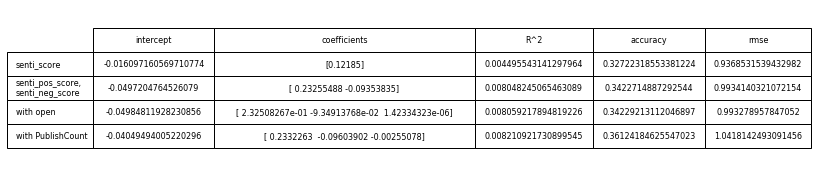

In [78]:
fig, ax = plt.subplots(figsize=(6,3))

# Hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.patch.set_linewidth('0.1')

table = ax.table(ModelEvaluation, colLabels=ModelEvaluationCol, rowLabels=ModelEvaluationRow, loc='center', cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1,2)
table.auto_set_column_width(col=list(range(len(ModelEvaluationCol))))

plt.show()
#plt.savefig('./results/evaluation_sentiment_Modelling.png')

In [100]:
print('senti_score:\n', pd.crosstab(test_set.prediction_sentiScore, test_set.stockPrice_Change, margins=True))
print('sentiPosNeg:\n', pd.crosstab(test_set.prediction_sentiPosNeg, test_set.stockPrice_Change, margins=True))
print('wOpen:\n', pd.crosstab(test_set.prediction_wOpen, test_set.stockPrice_Change, margins=True))
print('wPublishCount:\n', pd.crosstab(test_set.prediction_wPublishCount, test_set.stockPrice_Change, margins=True))

senti_score:
 stockPrice_Change         -1      0      1    All
prediction_sentiScore                            
-1                      3115   1972   2709   7796
0                      13694  12024  12939  38657
1                        600    678    713   1991
All                    17409  14674  16361  48444
sentiPosNeg:
 stockPrice_Change          -1      0      1    All
prediction_sentiPosNeg                            
-1                       4022   2826   3323  10171
0                       11395   9879  10358  31632
1                        1992   1969   2680   6641
All                     17409  14674  16361  48444
wOpen:
 stockPrice_Change     -1      0      1    All
prediction_wOpen                             
-1                  4015   2817   3319  10151
0                  11402   9886  10361  31649
1                   1992   1971   2681   6644
All                17409  14674  16361  48444
wPublishCount:
 stockPrice_Change            -1      0      1    All
prediction_wP

#### Export Linear Regression Sentiment Model

In [91]:
import joblib
joblib.dump(model_sentiPosNeg, './deployment/sentiment-model.pkl')

['./deployment/model.pkl']

### TF-IDF

#### Preparation of the DataSet

In [8]:
# subset of the DataFrame without some column (without any impact, just for overview)
data = data[['id','headline', 'stock', 'headline_cleaned','open','close', "stockPrice_Change"]]
# rename for identification after adding of TermMatrix (some columlabel might be in the headlines)
data = data.rename(columns={'headline': '_headline', 'headline_cleaned':'_headline_cleaned', 'stock': '_stock', 'open': '_open', 'close':'_close', 'stockPrice_Change':'_stockPrice_Change'})

In [9]:
# set index for Merge 
data = data.set_index('id')

In [10]:
# POS tagged and tokenzized Array to String
def tokenz_in_sentence(hl):
    word_list = hl[1:-1].split(", ")
    word_list = [word[1:-6] for word in word_list]
    sentence = ' '.join(word_list)
    return sentence

In [11]:
# apply new column with preProcessed headlines as sentences
data['_headline_sentence'] = data._headline_cleaned.apply(tokenz_in_sentence)
# as list
data_headlines = data['_headline_sentence'].tolist()

#### Term Frequency - Inverse Document Frequency

In [12]:
# Matrix of Token Counts
count_vectorizer = CountVectorizer(analyzer="word", stop_words="english")
# Matrix of Features
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english', smooth_idf=True, use_idf=True)

In [ ]:
# # # #!! some Allocation Error, Good Luck
# # # # apply matrix to the headlines
# # # count_wm = count_vectorizer.fit_transform(data_headlines)
# # # tfidf_wm = tfidf_vectorizer.fit_transform(data_headlines)
# # # # get columns
# # # count_tokenz = count_vectorizer.get_feature_names()
# # # tfidf_tokenz = tfidf_vectorizer.get_feature_names()
# # # # Make as DataFrame to Merge
# # # df_countvect = pd.DataFrame(data=count_wm.toarray(), index=data.index, columns=count_tokenz)
# # # df_tfidfvect = pd.DataFrame(data= tfidf_wm.toarray(), index=data.index, columns=tfidf_tokenz)

In [ ]:
# export the Matrixes because of some Allocation error sometimes #960sec
df_countvect.to_csv('../data/df_countvect.csv', index=False)
df_tfidfvect.to_csv('../data/df_tfidfvect.csv', index=False)

In [ ]:
df_countvect = pd.read_csv('../data/df_countvect.csv')
df_tfidfvect = pd.read_csv('../data/df_tfidfvect.csv')

In [ ]:
cols_to_delete = []
for column in df_tfidfvect:
    count = df_tfidfvect[df_tfidfvect[column] > 0].shape[0]
    if count<20:
        cols_to_delete.append(column)

print('Anzahl zu löschender Spalten (geringeres Vorkommen als 20) ',len(cols_to_delete))
print('Anzahl der Gesamt Spalten', df_tfidfvect.shape[1])

Anzahl zu löschender Spalten (geringeres Vorkommen als 20)  6278
Anzahl der Gesamt Spalten 8931


In [ ]:
# delete the Column that appier less than 20 times
df_tfidfvect.drop(axis=1, columns=cols_to_delete, inplace=True)

In [ ]:
#!! some Allocation Error, Good Luck 
# Merge the Headline-StockPrice-DataFrame with the TF_IDF-Matrix
data_with_tfidf = data.merge(df_tfidfvect, on='id')

##### Export der tfidf Matrix mit dem Datensatz, aufgrund von einigen Memory-Allocation-Error

In [ ]:
# export final DataSet as csv
data_with_tfidf.to_csv('../data/analyst_ratings_processed_final_tfidf_merged.csv')

In [ ]:
# import final DataSet for Modelling
# # # data_with_tfidf = pd.read_csv('../data/analyst_ratings_processed_final_tfidf_merged.csv')

#### Hyperparameter Tuning

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 100, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 3]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [30, 37, 45, 53, 61, 68, 76, 84, 92, 100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, None], 'min_samples_split': [2, 3], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


#### Random Forest

In [ ]:
# The TF-Matrix as Predictors without the metaData columns
X = data_with_tfidf.drop(columns=['id', '_headline', '_stock', '_headline_cleaned', '_open', '_close', '_stockPrice_Change', '_headline_sentence'])
# The Traget
y= data_with_tfidf['_stockPrice_Change']

In [ ]:
# Test and Train Split, 80percent Train
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=0)

In [ ]:
# export the feature list for deployment
feature_words = list(X_train)
dflist = pd.DataFrame(feature_words)
dflist.to_csv('../data/tfidf_features.csv', index=False)

In [ ]:
# Regressor with Parameters from Hypertuning
regressor = RandomForestRegressor( n_estimators=37, min_samples_split=2, min_samples_leaf=2, max_features='sqrt', max_depth=10, bootstrap=True)
# Training of the Model on the Train set
regressor.fit(X_train, y_train)
# Prediction on the Testset
y_pred = regressor.predict(X_test)

In [ ]:
# standartization of the Prediction
y_pred_bin = []
for value in y_pred:
    if value < 1:
        y_pred_bin.append(-1)
    elif value > 1:
        y_pred_bin.append(1)
    else: y_pred_bin.append(0)

#### Evaluation

In [ ]:
# make one Prediction
def predictHeadline(hl):

    count_hl = len(list(hl.split()))
    single_headline_tfidf = pd.DataFrame()
    feature_list = list(pd.read_csv('./deployment/app/tfidf_features.csv')['0'])
    for feature in feature_list:
        idf_value = tfidf_vectorizer.idf_[tfidf_vectorizer.vocabulary_[feature]]
        count_feature = hl.count(feature)
        single_headline_tfidf[feature] = [(count_feature / count_hl) * idf_value]
    print(regressor.predict(single_headline_tfidf))
    
# predictHeadline("stock very high best apple low")


In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred_bin))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred_bin))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_bin)))

Mean Absolute Error: 0.9746717859796878
Mean Squared Error: 1.6483775080505325
Root Mean Squared Error: 1.2838915483990587


In [ ]:
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred_bin))

Accuracy Score: 0.36218107505573444


#### Export TF-IDF RandomForest

In [ ]:
import joblib
joblib.dump(regressor, './deployment/tfidf_model.pkl')
joblib.dump(tfidf_vectorizer, './deployment/tfidf_vectorizer.pkl')

['./deployment/tfidf-model.pkl']